In [ ]:
# !curl http://files.fast.ai/data/dogscats.zip --output data/dogscats.zip
# !unzip data/dogscats.zip 

In [21]:
# !rm -rf data/dogscats

In [ ]:
# !unzip data/dogscats.zip -d data/loaded/

In [ ]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

- We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

# Import Libraries

In [1]:
import fastai

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/loaded/dogscats/"
sz = 224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['sample', 'train', 'tmp', 'models', 'test1', 'valid']

In [8]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [9]:
files = os.listdir(f'{PATH}valid/cats')[50:55]
files

['cat.6647.jpg',
 'cat.7382.jpg',
 'cat.12106.jpg',
 'cat.8508.jpg',
 'cat.9107.jpg']

In [10]:
sns.set_style('whitegrid')

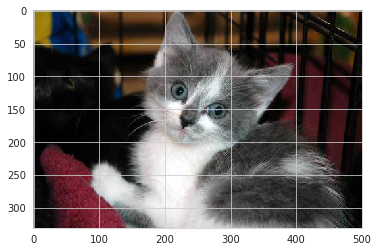

In [11]:
img = plt.imread(f'{PATH}valid/cats/{files[4]}')
plt.imshow(img);

In [12]:
img.shape

(331, 500, 3)

In [13]:
img[:4, :4]

array([[[136, 111,  11],
        [136, 111,  11],
        [137, 112,  11],
        [139, 114,  13]],

       [[136, 111,  11],
        [137, 112,  12],
        [138, 113,  12],
        [139, 114,  13]],

       [[137, 112,  12],
        [138, 113,  12],
        [139, 114,  13],
        [140, 115,  14]],

       [[138, 113,  12],
        [138, 113,  12],
        [139, 114,  13],
        [141, 116,  15]]], dtype=uint8)

- Here are the three lines of code necessary to train a model:
- We will be using the resnet34 model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on resnet models.

In [27]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.04856    0.036547   0.9875    
    1      0.046746   0.029336   0.988     



[array([0.02934]), 0.988]

In [20]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
data.classes

['cats', 'dogs']

- data contains the validation and training data
- learn contains the model

### Let’s make predictions for the validation set (predictions are in log scale):

In [23]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [24]:
log_preds[:10]

array([[ -0.00083,  -7.09779],
       [ -0.00009,  -9.30216],
       [ -0.00006,  -9.68648],
       [ -0.02193,  -3.83104],
       [ -0.     , -14.99545],
       [ -0.00005,  -9.87879],
       [ -0.00023,  -8.37799],
       [ -0.00008,  -9.46262],
       [ -0.00085,  -7.06729],
       [ -0.     , -12.53535]], dtype=float32)

In [28]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:, 1])

In [29]:
def rand_by_mask(mask): 
  return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct):
  return rand_by_mask((preds == data.val_y) == is_correct)

In [30]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
  f = plt.figure(figsize=figsize)
  for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims) // rows, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i])

In [31]:
def load_img_id(ds, idx):
  return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
  imgs = [load_img_id(data.val_ds, x) for x in idxs]
  title_probs = [probs[x] for x in idxs]
  print(title)
  return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs) > 0 else print('Not Found')

Correctly classified


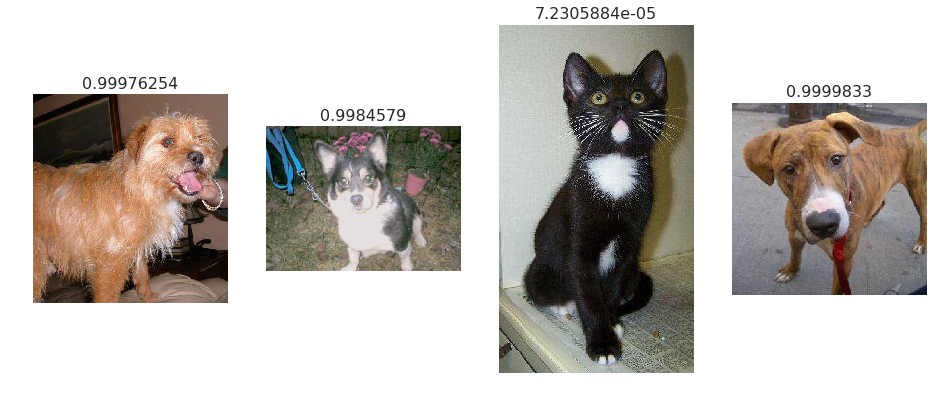

In [32]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


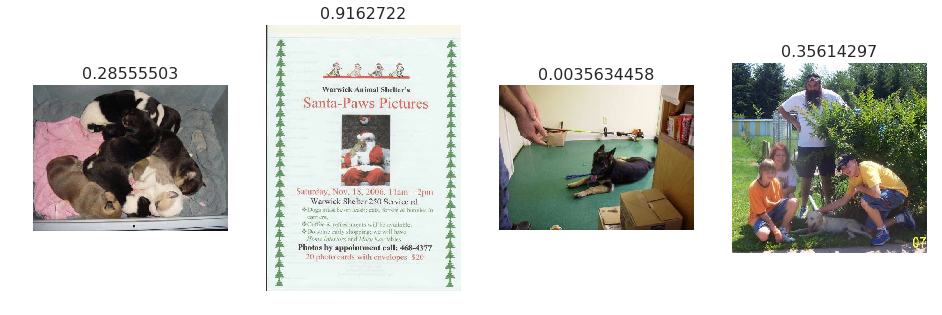

In [33]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [34]:
def most_by_mask(mask, mult):
  idxs = np.where(mask)[0]
  return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
  mult = -1 if(y==1)==is_correct else 1
  return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


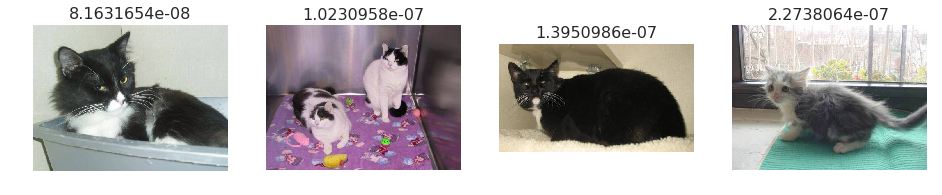

In [35]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


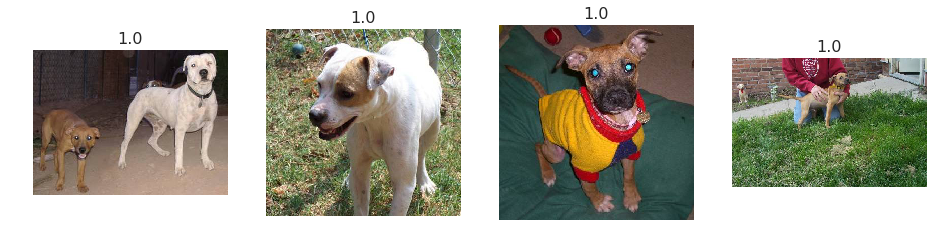

In [36]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


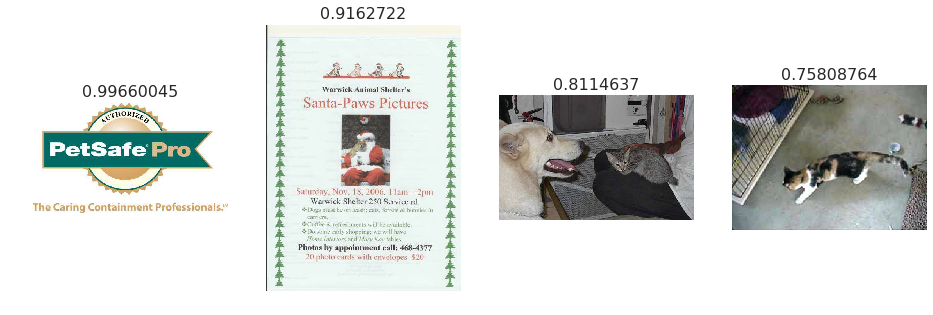

In [37]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


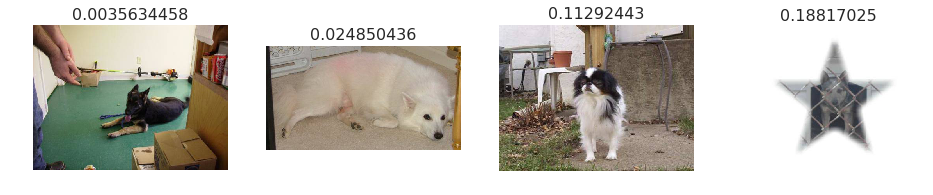

In [38]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


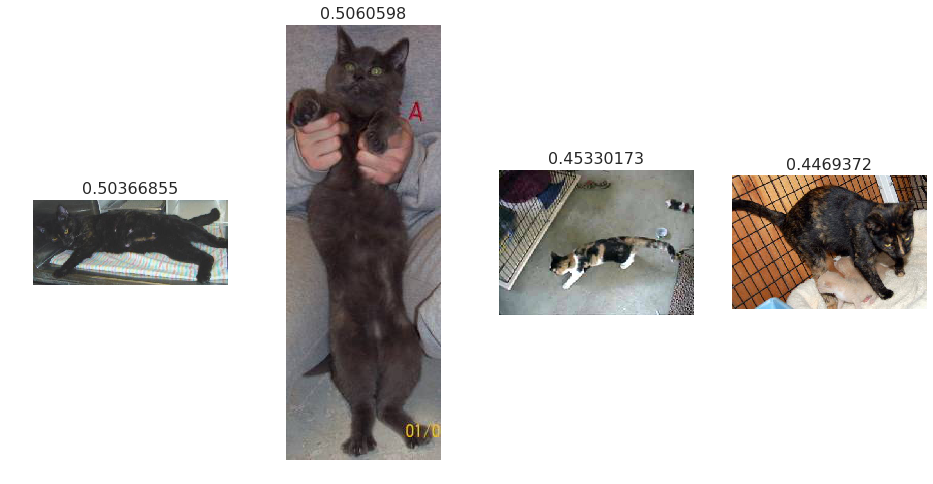

In [49]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [39]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [40]:
lrf=learn.lr_find()

 82%|████████▏ | 296/360 [00:06<00:01, 54.64it/s, loss=0.349]


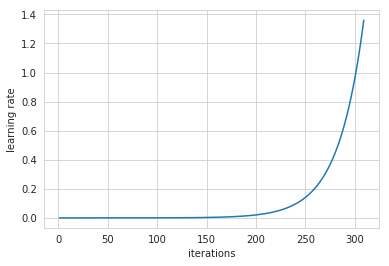

In [52]:
learn.sched.plot_lr()

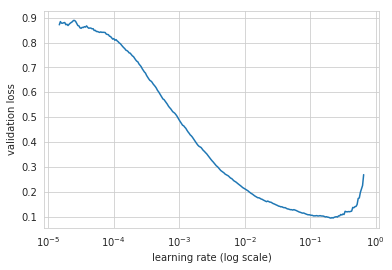

In [41]:
learn.sched.plot()

- Learning rate finder (learn.lr_find) will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. We then look at the plot of learning rate against loss, and determine the lowest point and go back by one magnitude and choose that as a learning rate (1e-2 in the example below).
- Mini-batch is a set of few images we look at each time so that we are using the parallel processing power of the GPU effectively (generally 64 or 128 images at a time)

### Improving our model

**Data Augmentation**

If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.



We can do this by passing aug_tfms (augmentation transforms) to tfms_from_model, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.

In [42]:
arch = resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.050464   0.028083   0.989     



[array([0.02808]), 0.989]

- transform_side_on — a predefined set of transformations for side-on photos (there is also transform_top_down). Later we will learn how to create custom transform lists.
- It is not exactly creating new data, but allows the convolutional neural net to learn how to recognize cats or dogs from somewhat different angles.

In [43]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [44]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [45]:
ims = np.stack([get_augs() for i in range(6)])

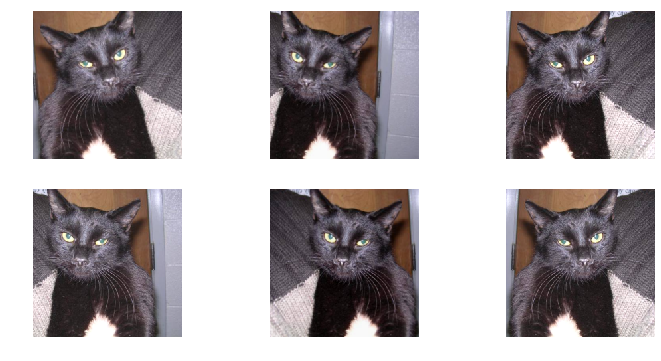

In [46]:
plots(ims, rows=2)

Let's create a new data object that includes this augmentation in the transforms.

In [47]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [60]:
learn.fit(1e-2, 1)


epoch      trn_loss   val_loss   accuracy   
    0      0.043448   0.027856   0.9905    


[array([0.02786]), 0.9905]

- Now we created a new data object that includes augmentation. Initially, the augmentations actually do nothing because of precompute=True.
- Convolutional neural network have these things called “activations.” An activation is a number that says “this feature is in this place with this level of confidence (probability)”. We are using a pre-trained network which has already learned to recognize features (i.e. we do not want to change hyper parameters it learned), so what we can do is to pre-compute activations for hidden layers and just train the final linear portion.
- This is why when you train your model for the first time, it takes longer — it is pre-computing these activations.
- Even though we are trying to show a different version of the cat each time, we had already pre-computed the activations for a particular version of the cat (i.e. we are not re-calculating the activations with the altered version).
- To use data augmentation, we have to do learn.precompute=False

In [61]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to frozen. That means that it's still only updating the weights in the last layer when we call fit.

In [48]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.056548   0.027928   0.991     
    1      0.039942   0.026812   0.991     
    2      0.041935   0.026278   0.99      



[array([0.02628]), 0.99]

- cycle_len=1: This enables stochastic gradient descent with restarts (SGDR). The basic idea is as you get closer and closer to the spot with the minimal loss, you may want to start decrease the learning rate (taking smaller steps) in order to get to exactly the right spot.
- The idea of decreasing the learning rate as you train is called learning rate annealing which is very common. Most common and “hacky” way to do this is to train a model with a certain learning rate for a while, and when it stops improving, manually drop down the learning rate (stepwise annealing).
- A better approach is simply to pick some kind of functional form — turns out the really good functional form is one half of the cosign curve which maintains the high learning rate for a while at the beginning, then drop quickly when you get closer.
- We may find ourselves in a part of the weight space that isn’t very resilient — that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the ‘restarts’ in ‘SGDR’), which will force the model to jump to a different part of the weight space if the current area is “spiky”. 

The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is referred to as the number of cycles, and is what we're actually passing as the 2nd parameter to fit()

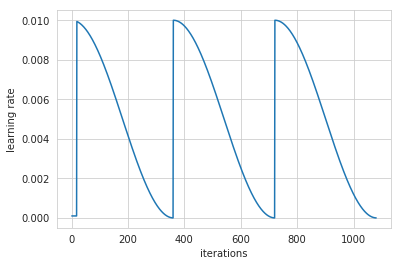

In [49]:
learn.sched.plot_lr()

In [50]:
learn.save('224_lastlayer')

In [51]:
learn.load('224_lastlayer')

- When you precompute activations or create resized images (we will learn about it soon), various temporary files get created which you see under data/dogcats/tmp folder. If you are getting weird errors, it might be because of precomputed activations that are only half completed or are in some way incompatible with what you are doing. So you can always go ahead and delete this /tmp folder to see if it makes the error go away (fast.ai equivalent of turning it off and then on again).

- You will also see there is a directory called /models that is where models get saved when you say learn.save

#### Fine-tuning and differential learning rate annealing

- So far, we have not retrained any of pre-trained features — specifically, any of those weights in the convolutional kernels. All we have done is we added some new layers on top and learned how to mix and match pre-trained features.


In [52]:
learn.unfreeze()

- frozen layer is a layer which is not being trained/updated. unfreeze unfreezes all the layers.
- the earlier layers have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as differential learning rates, although there's no standard name for this techique in the literature that we're aware of.

In [53]:
lr=np.array([1e-4,1e-3,1e-2])

In [54]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.051997   0.027091   0.991     
    1      0.046412   0.026656   0.9905    
    2      0.049249   0.029219   0.9885    
    3      0.047524   0.025753   0.9905    
    4      0.040371   0.025456   0.989     
    5      0.033419   0.024772   0.99      
    6      0.037576   0.024772   0.99      



[array([0.02477]), 0.99]

- cycle_len=2: it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of 
- cycle_mult=2: this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

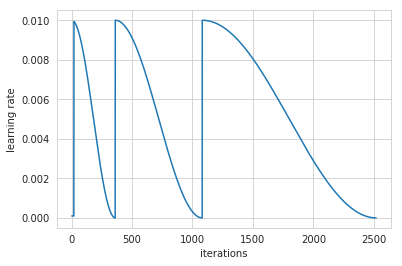

In [55]:
learn.sched.plot_lr()

if the cycle length is too short, it starts going down to find a good spot, then pops out, and goes down trying to find a good spot and pops out, and never actually get to find a good spot. Earlier on, you want it to do that because it is trying to find a spot that is smoother, but later on, you want it to do more exploring. That is why cycle_mult=2 seems to be a good approach.

In [56]:
learn.save('224_all')

In [57]:
learn.load('224_all')

## Test Time Augmentation (TTA)

- There is something else we can do with data augmentation: use it at inference time (also known as test time). Not surprisingly, this is known as test time augmentation, or just TTA.

- TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's TTA() method.

In [58]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [59]:
accuracy_np(probs, y)

0.9905

### Analyzing results

#### Confusion Matrix

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[991   9]
 [ 10 990]]


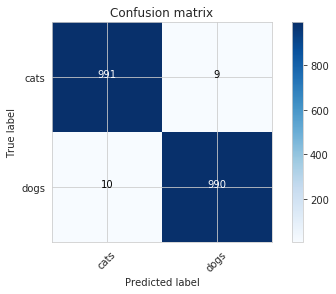

In [62]:
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


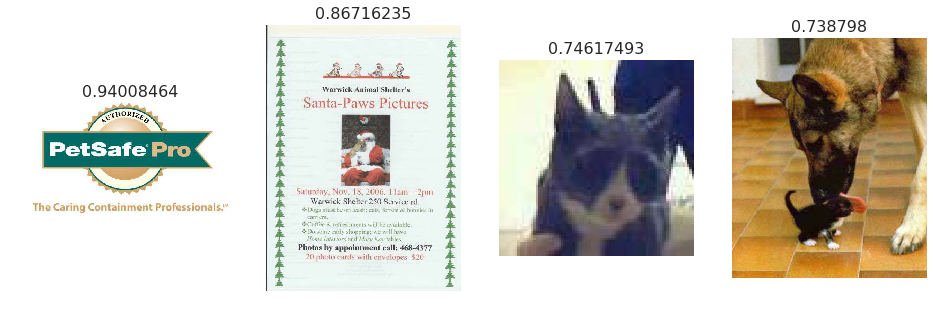

In [63]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


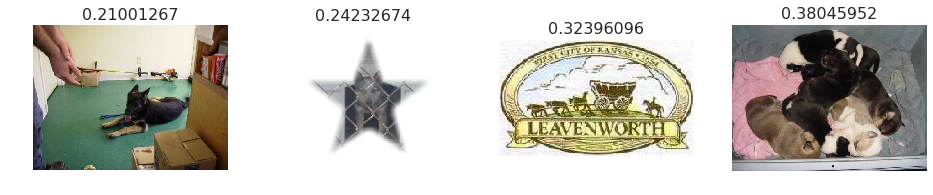

In [64]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

# Review: easy steps to train a world-class image classifier¶

1. Precompute=True
2. Use lr_find() to find the highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting